In [2]:
from snowpack_functions import make_map, mesh_gridify, unpack_netcdf_file_var
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math 
%matplotlib inline 
## each figure: 1970-1999, 2010-2039, 2040-2069,2070-2099 (2 x 4, with first halfway between rows 1 and 2) 
## fileformat: pr_ensavg_rcp85_whites_2040-2069.nc

variables = ["pr","temp"]
# variables = ["pr"]
chunks = ["1970-1999","2010-2039","2040-2069","2070-2099","1970-1999","2010-2039","2040-2069","2070-2099"] 
scenarios = ["historical","rcp45","rcp45","rcp45","historical","rcp85","rcp85","rcp85"] 
# basins = ["california","cascades","northernrockies","southernrockies","whites"] 
basins = ["missouri","lower_colorado","great_basin","nwinterior","coastalsouth","coastalnorth"]
models = ['CNRM-CM5','NorESM1-M','IPSL-CM5A-MR','CanESM2','CCSM4','HadGEM2-CC365','HadGEM2-ES365','MIROC5','bcc-csm1-1-m',
          'CSIRO-Mk3-6-0']
# scenario = "historical"
# basin = "whites"

In [3]:
timeperiods = ["historical","rcp45","rcp85"]
for variable in variables: 
    for basin in basins: 
        for num in np.arange(len(scenarios)):

            if chunks[num] == "1970-1999":
                varname = 'var'
            elif chunks[num] == "2010-2039":
                varname = 'chunk1'
            elif chunks[num] == "2040-2069":
                varname = 'chunk2'
            else:
                varname = 'chunk3'

            direc = '/raid9/gergel/agg_snowpack/climatology/arrays'
            filename = '%s_%s_%s_%s_mam.npz' %('pr',basin,'NorESM1-M',scenarios[num])
            data = np.load(os.path.join(direc,filename))
            lats_inc = data['lats']
            lons_inc = data['lons']
            arr_mods = np.ndarray(shape=(10,len(lats_inc)),dtype=float) ## array for multimodel average 
            modelcount = 0
            for model in models:
                if (variable == "pr"):
                    filename = '%s_%s_%s_%s_mam.npz' %('pr',basin,model,scenarios[num])
                    data = np.load(os.path.join(direc,filename))
                    var = data[varname]
                    arr_mods[modelcount,:] = var
                    modelcount += 1 ## iterate count
                else:
                    arr_temp = np.ndarray(shape=(2,len(lats_inc)),dtype=float) ## array for temp average
                    file1 = '%s_%s_%s_%s_mam.npz' %('tasmin',basin,model,scenarios[num])
                    file2 = '%s_%s_%s_%s_mam.npz' %('tasmax',basin,model,scenarios[num])
                    data1 = np.load(os.path.join(direc,file1))
                    data2 = np.load(os.path.join(direc,file2))
                    arr_temp[0,:] = data1[varname]
                    arr_temp[1,:] = data2[varname]
                    temp_avg = np.mean(arr_temp,axis=0) ## average temp from tmax and tmin
                    arr_mods[modelcount,:] = temp_avg ## add to model average array
                    modelcount += 1 ## iterate count

            model_avg = np.mean(arr_mods,axis=0) ## multimodel average

            filearrayname = '/raid9/gergel/agg_snowpack/climatology/arrays/%s_%s_%s_%s_mam.npz' %(variable,basin,scenarios[num],chunks[num])
            np.savez(filearrayname,lats=lats_inc,lons=lons_inc,var=model_avg)

saving figure to /raid9/gergel/agg_snowpack/climatology/plots/pr_lowlands
saving figure to /raid9/gergel/agg_snowpack/climatology/plots/temp_lowlands


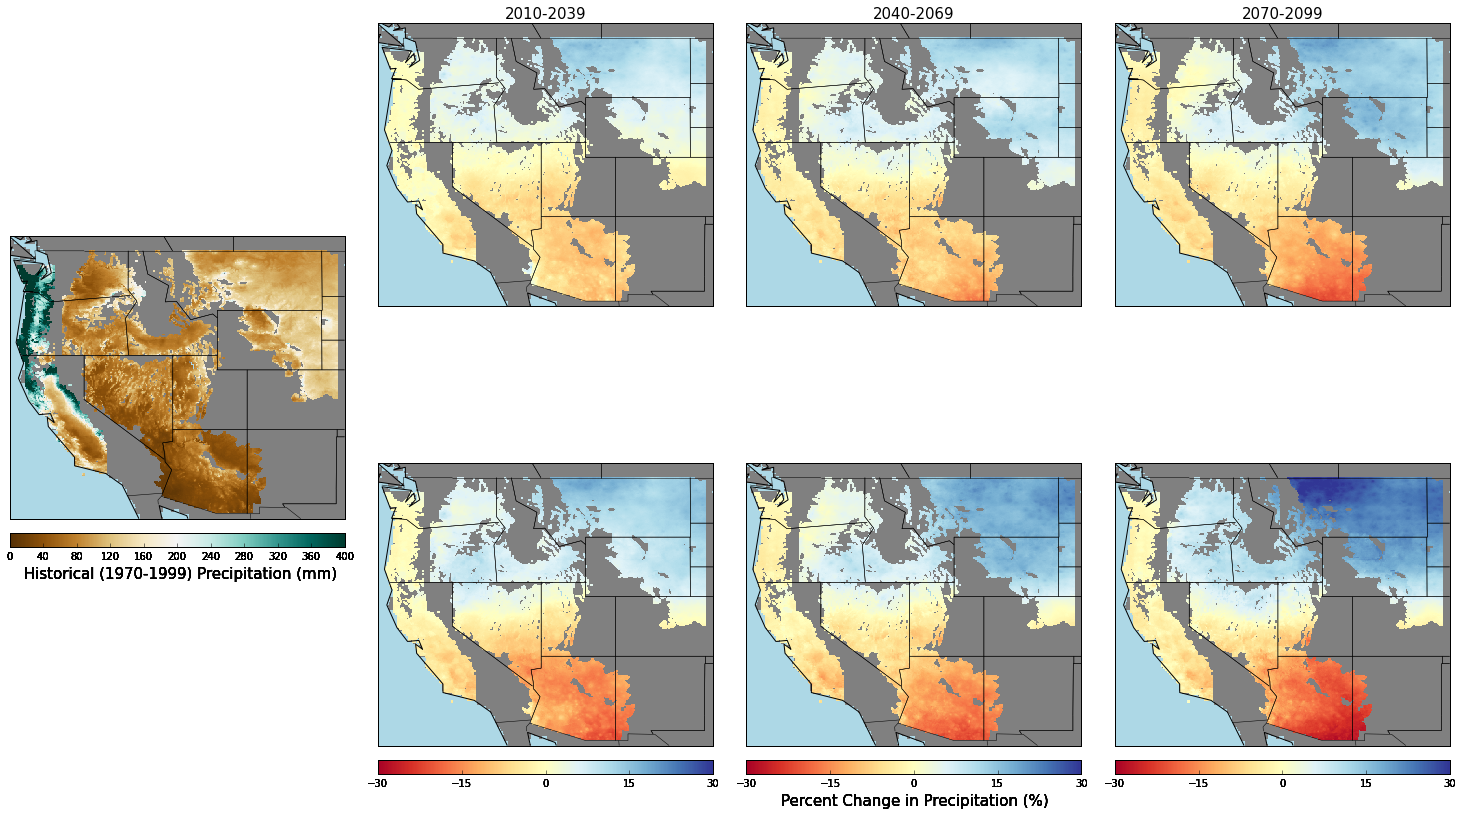

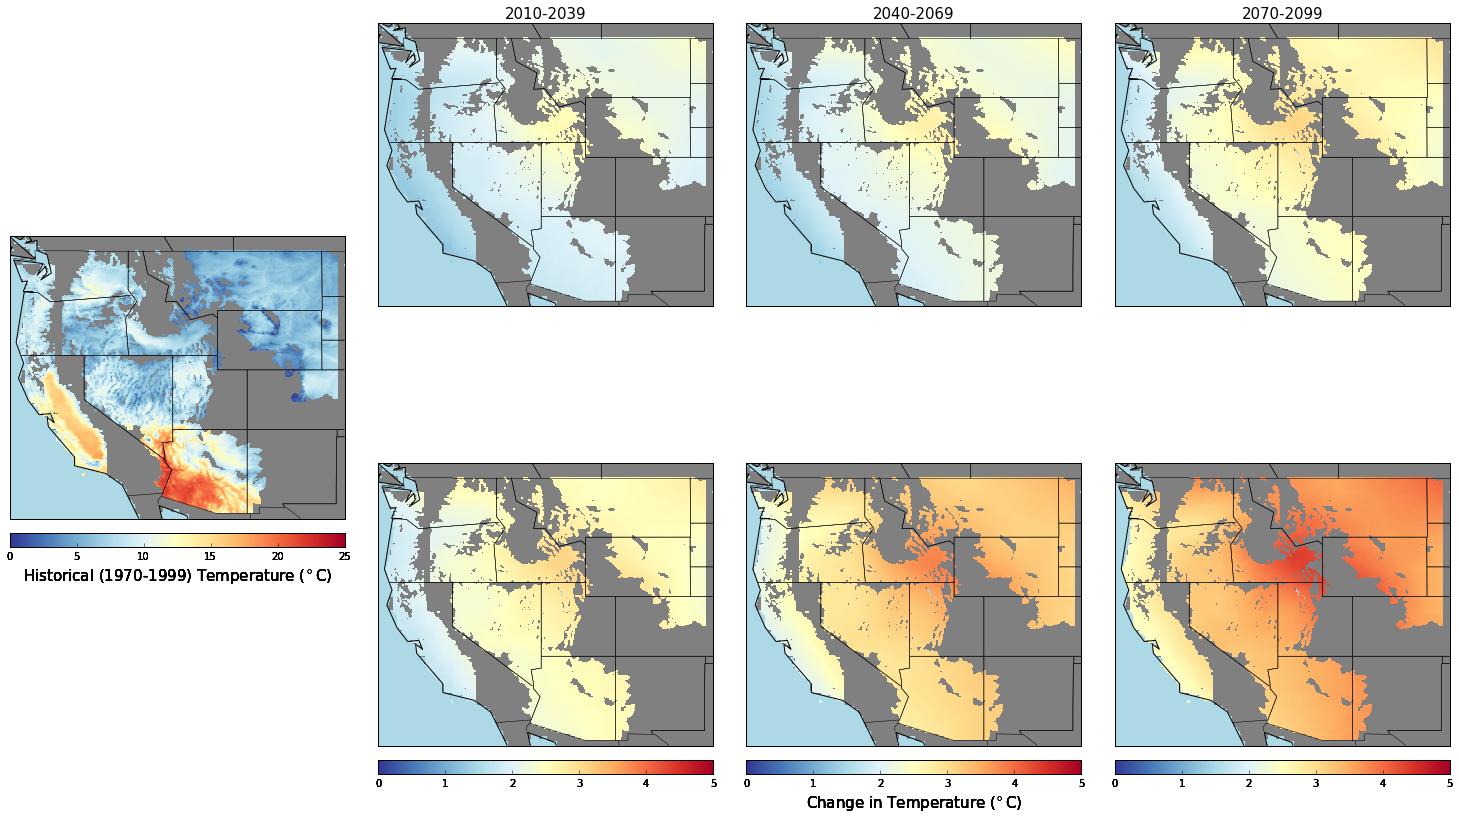

In [11]:
###################################################### MAKE FIGURE ###############################################################
## (10,7)
from pylab import *
%matplotlib inline
from snowpack_functions import make_map
lt = 20
rt = 14
variables = ["pr","temp"]
# chunks = ["1970-1999","2010-2039","2040-2069","2070-2099","1970-1999","2010-2039","2040-2069","2070-2099"] 
chunks = ["2010-2039","2040-2069","2070-2099","2010-2039","2040-2069","2070-2099","1970-1999"] 
# scenarios = ["historical","rcp45","rcp45","rcp45","historical","rcp85","rcp85","rcp85"] 
scenarios = ["rcp45","rcp45","rcp45","rcp85","rcp85","rcp85","historical"] 
sps = np.asarray([2,3,4,6,7,8,9])
for variable in variables: 
    fig = plt.figure(figsize=(lt,rt))
    for num in np.arange(len(chunks)):
        
        if sps[num] < 9: 
            ax = fig.add_subplot(2,4,sps[num]) ## add subplots 
        else: 
            ax = fig.add_subplot(1,4,1)
        m = make_map()
        if sps[num] < 6:
            ax.set_title(chunks[num],fontsize=15) ## titles for top row of figures 
            
        for basin in basins: 
            ## historical data 
            direc = '/raid9/gergel/agg_snowpack/climatology/arrays'
            filename = '%s_%s_%s_%s_mam.npz' %(variable,basin,"historical","1970-1999")
            data = np.load(os.path.join(direc,filename))
            var_series_hist = data['var']
            var_series = var_series_hist[var_series_hist > 0] ## get rid of vestigial zeroes
            
            
            filename = '%s_%s_%s_%s_mam.npz' %('pr',basin,"rcp45","2010-2039")
            data = np.load(os.path.join(direc,filename))
            lats_inc = data['lats']
            lons_inc = data['lons']
            
            lats_inc = lats_inc[var_series_hist > 0]
            lons_inc = lons_inc[var_series_hist > 0]
            
            if (variable == "temp"):
                var_series = var_series - 273.15
            lons_mesh,lats_mesh,data_mesh_h = mesh_gridify(lats_inc.reshape(len(lats_inc),1),lons_inc.reshape(len(lats_inc),1),
                                                         var_series.reshape(len(lats_inc),1)) 
            if (scenarios[num] == "historical"): ## plot historical data
                if (variable == "pr"):
                    cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh_h,shading='flat',cmap='BrBG',latlon=True,zorder=1,
                                      vmin=0,vmax=400)
                else: 
                    cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh_h,shading='flat',cmap='RdYlBu_r',latlon=True,zorder=1,
                                      vmin=0,vmax=25)
            else: 
                filename = '%s_%s_%s_%s_mam.npz' %(variable,basin,scenarios[num],chunks[num])
                data = np.load(os.path.join(direc,filename))
                var_series = data['var']
                var_series = var_series[var_series_hist > 0]
                if (variable == "temp"):
                    var_series = var_series - 273.15
                
                lons_mesh,lats_mesh,data_mesh = mesh_gridify(lats_inc.reshape(len(lats_inc),1),lons_inc.reshape(len(lats_inc),1),
                                                             var_series.reshape(len(lats_inc),1)) 
                
                if (variable == "pr"): 
                    data_mesh = np.divide(np.subtract(data_mesh,data_mesh_h),data_mesh_h)*100
                else:
                    data_mesh = np.subtract(data_mesh,data_mesh_h)
                    
                if (variable == "pr"):
                    cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu',latlon=True,zorder=1,
                                      vmin=-30,vmax=30)
                else: 
                    cs = m.pcolormesh(lons_mesh,lats_mesh,data_mesh,shading='flat',cmap='RdYlBu_r',latlon=True,zorder=1,
                                      vmin=0,vmax=5)
            if num >= 3 and num < 7:
                cbar = m.colorbar(cs, location='bottom',pad="5%")
                if (scenarios[num] == "historical") and (variable == "pr"):
                    cbar = m.colorbar(cs, location='bottom',pad="5%")
                    cbar.set_ticks([0,150,300,450,600])
                    # cbar.set_ticklabels([0,100,200,300,400,500,600])
                    cbar.set_label(' Historical (1970-1999) Precipitation (mm)',size=15)
                elif (scenarios[num] == "historical") and (variable == "temp"):
                    cbar.set_ticks([0,5,10,15,20,25])
                    cbar.set_label('Historical (1970-1999) Temperature ($^\circ$C)',size=15)
                elif(scenarios[num] != "historical") and (variable == "pr"): 
                    cbar.set_ticks([-30,-15,0,15,30])
                else: 
                    cbar.set_ticks([0,1,2,3,4,5])
            elif num == 5 and (variable == "temp"):
                cbar = m.colorbar(cs, location='bottom',pad="5%",extend='max')
                '''if (scenarios[num] == "historical") and (variable == "pr"):
                    cbar.set_ticks([0,100,200,300,400,500,600])'''
                if (scenarios[num] == "historical") and (variable == "temp"):
                    cbar.set_ticks([-10,-5,0,5])
                elif(scenarios[num] != "historical") and (variable == "pr"): 
                    cbar.set_ticks([-30,-15,0,15,30])
                else: 
                    cbar.set_ticks([1,2,3,4,5])
            if num == 4 and (variable == "temp"):
                cbar.set_label('Change in Temperature ($^\circ$C)',size=15)
            elif num == 4 and (variable == "pr"):
                cbar.set_label('Percent Change in Precipitation (%)',size=15)
            
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0.1,hspace=0.00000001,wspace=0.1)
    ## save figure
    direc = '/raid9/gergel/agg_snowpack/climatology/plots'
    plotname = '%s_lowlands' %variable 
    savepath = os.path.join(direc,plotname)
    print("saving figure to %s" %savepath)
    plt.savefig(savepath)

In [5]:
direc = '/raid9/gergel/agg_snowpack/climatology/arrays'
filename = '%s_%s_%s_%s_mam.npz' %('pr','lower_colorado',"historical","1970-1999")
np.load(os.path.join(direc,filename))
g = data['var']
np.min(g)

63.961127115885418